In [1]:
import pandas
import numpy as np
import os

from utils import selectProtGenes, removeConstantValues
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import Callback, ModelCheckpoint
from keras import regularizers

In [3]:
dataPath = '../data'
seed = 42
testSizeRatio = 0.33

In [4]:
print('[INFO] Loading Dataset')
data = pandas.read_csv(os.path.join(dataPath, 'dataset.csv'))
columnsNames = data.iloc[:,5:-1].columns.values

[INFO] Loading Dataset


In [5]:
print('[INFO] Separating Labels from Data')
X = data.iloc[:,5:-1].values
Y = data.iloc[:, -1].values

y = np.array([0 if label == 'Solid Tissue Normal' else 1 for label in Y])

[INFO] Separating Labels from Data


In [6]:
a = np.array(Y)
unique, counts = np.unique(a, return_counts=True)
print(dict(zip(unique, counts)))

{'Metastatic': 8, 'Primary Tumor': 502, 'Solid Tissue Normal': 58}


In [7]:
with open(os.path.join(dataPath, 'protCodingGenesNoIsomorphs.txt')) as f:
    protGenes = f.read()
f.closed

protGenesList = protGenes.split('\n') #19147 genes
print('[INFO] Selecting only the genes that produce proteins')
df = pandas.DataFrame(X, columns=columnsNames)
newX = selectProtGenes(df, protGenesList)

[INFO] Selecting only the genes that produce proteins


In [8]:
print('[INFO] Removing Zero Expression Genes')
newX = removeConstantValues(newX)

[INFO] Removing Zero Expression Genes


In [55]:
newX.describe()

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000279968.1,ENSG00000280090.1,ENSG00000280094.1,ENSG00000280165.1,ENSG00000280236.1,ENSG00000280267.2,ENSG00000280670.1,ENSG00000280789.1,ENSG00000280969.1,ENSG00000281106.1
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,...,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,13.480151,0.038858,24.411179,2.445994,0.634909,3.297082,14.025450,23.880482,5.452824,9.919418,...,0.193035,0.000025,0.000376,0.016667,0.000520,0.000019,1.185737,5.745020,0.013879,0.012197
std,4.014049,0.071818,4.720777,0.643267,0.209722,2.563183,11.956581,4.828360,4.055370,2.589152,...,0.107004,0.000600,0.002402,0.063542,0.006983,0.000453,0.938940,1.582164,0.035237,0.027185
min,0.650256,0.000000,3.379340,0.636587,0.031470,0.292606,0.153211,7.076953,0.870851,2.579666,...,0.020426,0.000000,0.000000,0.000000,0.000000,0.000000,0.139140,1.167532,0.000000,0.000000
25%,10.774082,0.008194,21.744340,1.989970,0.481107,1.524284,4.514743,20.823537,3.912986,8.442415,...,0.119269,0.000000,0.000000,0.000000,0.000000,0.000000,0.460046,4.677780,0.000000,0.000000
50%,13.080501,0.020888,24.165120,2.451985,0.635745,2.656106,11.662339,23.380897,4.854067,9.940825,...,0.171544,0.000000,0.000000,0.003992,0.000000,0.000000,0.873180,5.618915,0.000000,0.004950
75%,16.048695,0.044359,27.002182,2.873230,0.781460,4.303123,19.972506,26.188263,6.033969,11.562251,...,0.235243,0.000000,0.000000,0.012637,0.000000,0.000000,1.725785,6.749239,0.000000,0.012716
max,27.981840,0.888517,41.917406,4.899258,1.241166,21.910821,71.434857,53.188072,66.665259,18.984943,...,1.150037,0.014308,0.019660,1.055494,0.160010,0.010796,6.474588,11.846847,0.293861,0.436669


Let's create the basic autoencoder, as a single fully-connected neural layer.

In [9]:
def basicAutoEncoder(encodingDim = 128):
    def factory(X):
        _, dim = X.shape 

        inputLayer = Input(shape=(dim,))
        # "encoded" is the encoded representation of the input
        encoded = Dense(encodingDim, activation='relu')(inputLayer)
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(dim, activation='relu')(encoded)
        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, encoded)

        return autoencoder,encoder
    return factory

In [10]:
def denoisingAutoEncoder(dropout=0.1,encodingDim = 128):
    def factory(X):
        _, dim = X.shape 

        inputLayer = Input(shape=(dim,))
        # "encoded" is the encoded representation of the input
        encoded = Dense(encodingDim, activation='relu')(Dropout(dropout)(inputLayer))
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(dim, activation='relu')(encoded)
        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, encoded)

        return autoencoder,encoder
    
    return factory

In [11]:
def sparseAutoEncoder(reg=10e-5,encodingDim = 128):
    def factory(X):
        _, dim = X.shape
        
        inputLayer = Input(shape=(dim,))
        encoded = Dense(encodingDim, activation='relu', activity_regularizer=regularizers.l1(reg))(inputLayer)
        decoded = Dense(dim, activation='relu')(encoded)

        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, encoded)

        return autoencoder, encoder
    
    return factory

In [12]:
def sparseBNAutoEncoder(reg=10e-5,encodingDim = 128):
    def factory(X):
        _, dim = X.shape
        
        inputLayer = Input(shape=(dim,))
        bn = BatchNormalization()(inputLayer)
        encoded = Dense(encodingDim, activation='relu', activity_regularizer=regularizers.l1(reg))(bn)
        decoded = Dense(dim, activation='relu')(encoded)

        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, encoded)

        return autoencoder, encoder
    
    return factory

In [13]:
def denoisingSparseAutoEncoder(reg=10e-5,encodingDim = 256,dropout=0.1):
    def factory(X):
        _, dim = X.shape
        
        inputLayer = Input(shape=(dim,))
        encoded = Dense(encodingDim, activation='relu', activity_regularizer=regularizers.l1(reg))(Dropout(dropout)(inputLayer))
        decoded = Dense(dim, activation='relu')(encoded)

        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, encoded)

        return autoencoder, encoder
    
    return factory

In [14]:
def deepAutoEncoder(dims=[512, 256, 128]):
    def factory(X):
        _, dim = X.shape
        
        inputLayer = Input(shape=(dim,))
        e1 = Dense(dims[0], activation='relu')(inputLayer)
        e2 = Dense(dims[1], activation='relu')(e1)
        e3 = Dense(dims[2], activation='relu')(e2)
        d2 = Dense(dims[1], activation='relu')(e3)
        d1 = Dense(dims[0], activation='relu')(d2)
        decoded = Dense(dim, activation='relu')(d1)

        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, e3)

        return autoencoder, encoder
    
    return factory

In [15]:
def deepSparseDenoisingAutoEncoder(dims=[512, 256, 128],reg=10e-5,dropout=0.1):
    def factory(X):
        _, dim = X.shape
        
        inputLayer = Input(shape=(dim,))
        e1 = Dense(dims[0], activation='relu', activity_regularizer=regularizers.l1(reg))(Dropout(dropout)(inputLayer))
        e2 = Dense(dims[1], activation='relu', activity_regularizer=regularizers.l1(reg))(e1)
        e3 = Dense(dims[2], activation='relu', activity_regularizer=regularizers.l1(reg))(e2)
        d2 = Dense(dims[1], activation='relu')(e3)
        d1 = Dense(dims[0], activation='relu')(d2)
        decoded = Dense(dim, activation='relu')(d1)

        autoencoder = Model(inputLayer, decoded)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        encoder = Model(inputLayer, e3)

        return autoencoder, encoder
    
    return factory

In [16]:
import keras_metrics

def buildClassifier(inputDim):
    inputLayer = Input(shape=(inputDim,))
    x = BatchNormalization()(inputLayer)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    predLayer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputLayer, outputs=predLayer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])
    return model

In [17]:
import keras_metrics

def buildClassifierWithInit(topModel, allowAEFineTune = True):
    for layer in topModel.layers:
        layer.trainable = allowAEFineTune
        
    x = BatchNormalization()(topModel.output)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    predLayer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=topModel.input, outputs=predLayer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])

    return model

# Here commences the tests!

In [18]:
def getBestByKey(hist, key = 'val_loss', f = min):
    ix = hist.history[key].index(f(hist.history[key]))
    return [hist.history[k][ix] for k in hist.history.keys()]

def summarizeMetrics(historics, key = 'val_loss', f = min):
    metrics = [getBestByKey(h, key, f) for h in historics]
    result = pandas.DataFrame(metrics, columns=historics[0].history.keys())

    return result

def summarizeKFold(hists, key = 'val_loss', f = min):
    means = pandas.concat([summarizeMetrics(hists[i], key, f).mean(axis=0) for i in [0, 1]], axis=1).transpose()
    devs = pandas.concat([summarizeMetrics(hists[i], key, f).std(axis=0) for i in [0, 1]], axis=1).transpose()
    return means.applymap(lambda x: '%.2f%%' % (x * 100)) + devs.applymap(lambda x: ' (±%.2f%%)' % (x * 100))

def summarizeKFold2(hists, key = 'val_loss', f = min):
    means = pandas.concat([summarizeMetrics(hists[i], key, f).mean(axis=0) for i in [0, 1]], axis=1).transpose()
    devs = pandas.concat([summarizeMetrics(hists[i], key, f).std(axis=0) for i in [0, 1]], axis=1).transpose()
    means.iloc[:,0] = means.iloc[:,0].apply(lambda x: round(x, 3))
    devs.iloc[:,0] = means.iloc[:,0].apply(lambda x: round(x, 3))
    means.iloc[:,1:] = means.iloc[:,1:].applymap(lambda x: '%.2f%%' % (x * 100))
    devs.iloc[:,1:] = devs.iloc[:,1:].applymap(lambda x: ' (±%.2f%%)' % (x * 100))
    return means + devs

In [19]:
def experienceB(X, y, aeFactory, nEpochsAE = 100, nEpochs = 100, batchSize=100, trainVerbose=True,aeFineTune=True,nFolds=3):    
    ## Let's guarantee the reproducability of the results (!)
    from tensorflow import set_random_seed
    np.random.seed(seed)
    set_random_seed(seed)
    xValResults = ([], []) #1st is encoder, 2nd is ae
    
    folds = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=seed)
    
    currentFold = 1
    for train, val in folds.split(X, y):
        XTrain = X.values[train]
        yTrain = y[train]
        XVal = X.values[val]
        yVal = y[val]
        
        autoencoder, encoder = aeFactory(XTrain)
        
        print(encoder.summary())
        print(autoencoder.summary())
        
        ## First we train the autoencoder    
        filepath = "autoencoder.best.hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=trainVerbose, save_best_only=True, mode='min')

        print('[FOLD %d] Training Autoencoder' % currentFold)
        autoencoder.fit(XTrain, XTrain, epochs=nEpochsAE, batch_size=batchSize, validation_data=(XVal, XVal),verbose=trainVerbose, callbacks = [checkpoint])

        historials = []

        for (model, name) in [(encoder, "Encoder"), (autoencoder, "Autoencoder")]:
            ## Use encoded layer to predict 
            print('[FOLD %d] Finetuning model with top layers from %s' % (currentFold, name))
            autoencoder.load_weights(filepath)
            encoderBasedModel = buildClassifierWithInit(model,aeFineTune)
            
            print(encoderBasedModel.summary())
            
            historials.append(encoderBasedModel.fit(XTrain, yTrain, batch_size=batchSize, epochs=nEpochs, validation_data=(XVal, yVal), verbose=trainVerbose))
        
        xValResults[0].append(historials[0])
        xValResults[1].append(historials[1])

        currentFold += 1

    return xValResults

In [20]:
def experienceC(X, y, aeFactory, nEpochsAE = 100, batchSize=100, trainVerbose=True, nFolds=3):    
    ## Let's guarantee the reproducability of the results (!)
    from tensorflow import set_random_seed
    np.random.seed(seed)
    set_random_seed(seed)
    xValResults = []
    
    folds = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=seed)
    
    currentFold = 1
    for train, val in folds.split(X, y):
        XTrain = X.values[train]
        yTrain = y[train]
        XVal = X.values[val]
        yVal = y[val]
        
        autoencoder, _ = aeFactory(XTrain)
        
        #filepath = "autoencoder.best.hdf5"
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=trainVerbose, save_best_only=True, mode='min')

        print('[FOLD %d] Training Autoencoder' % currentFold)
        hists = autoencoder.fit(XTrain, XTrain, epochs=nEpochsAE, batch_size=batchSize, validation_data=(XVal, XVal),verbose=trainVerbose)
        
        xValResults.append(hists.history)
        
        currentFold += 1

    return xValResults

In [21]:
def valLosses(hists, key='val_loss'):
    values = np.array([h[key] for h in hists])
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    means = np.mean(values, axis=0)
    return means, mins, maxs

In [22]:
def drawLoss(l,filename=None,ylim=[1000,30000]):
    import math
    import matplotlib.pyplot as plt
    %matplotlib inline

    y = np.min(l[1])
    x = np.argmin(l[1])
    label = 'Minima: ' + str(math.floor(y))

    plt.ylim(ylim)
    plt.yscale('log')
    plt.plot(l[0])
    plt.plot(x, y, 'x', color='black', label=label)
    plt.legend()
    plt.fill_between(x=range(0,len(l[0])), y1=l[1], y2=l[2], color=(0,0,0,0.1))
    
    if filename is not None: plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    plt.show()
    
    

In [39]:
AEloss = experienceC(newX, y, basicAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False, nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [40]:
DAELoss = experienceC(newX, y, denoisingAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False,nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [41]:
SAELoss = experienceC(newX, y, sparseAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False,nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [42]:
DSAELoss = experienceC(newX, y, denoisingSparseAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False,nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [23]:
DpLoss = experienceC(newX, y, deepAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False,nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [24]:
DSDAELoss = experienceC(newX, y, deepSparseDenoisingAutoEncoder(), nEpochsAE = 1000, batchSize=100, trainVerbose=False,nFolds=5)

[FOLD 1] Training Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 5] Training Autoencoder


In [ ]:
drawLoss(valLosses(AEloss, 'loss'), filename='plotLoss_AE_train.pdf', ylim=[300,50000])

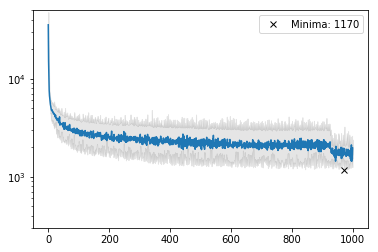

In [188]:
drawLoss(valLosses(DAELoss), filename='plotLoss_DAE.pdf', ylim=[300,50000])

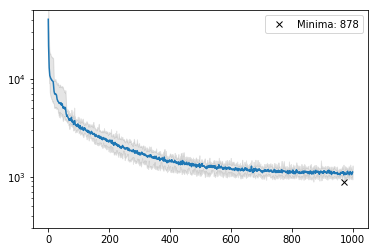

In [189]:
drawLoss(valLosses(SAELoss), filename='plotLoss_SAE.pdf', ylim=[300,50000])

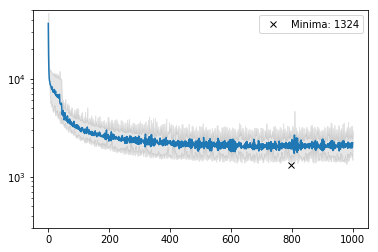

In [190]:
drawLoss(valLosses(DSAELoss), filename='plotLoss_DSAE.pdf', ylim=[300,50000])

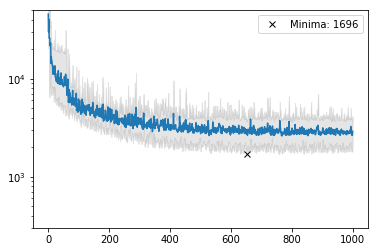

In [25]:
drawLoss(valLosses(DpLoss), filename='plotLoss_DP.pdf', ylim=[300,50000])

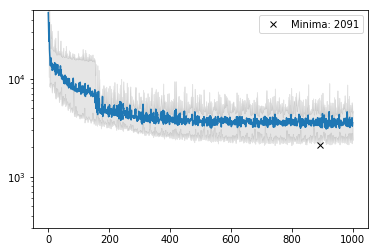

In [31]:
drawLoss(valLosses(DSDAELoss), filename='plotLoss_DSDAE.pdf', ylim=[300,50000])

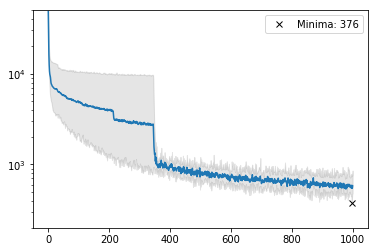

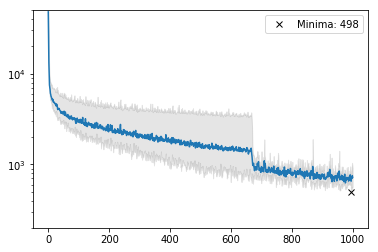

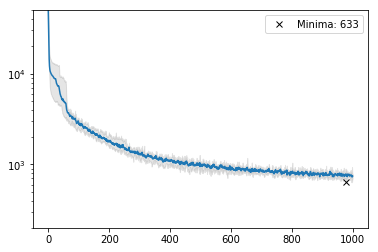

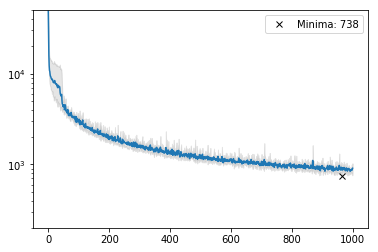

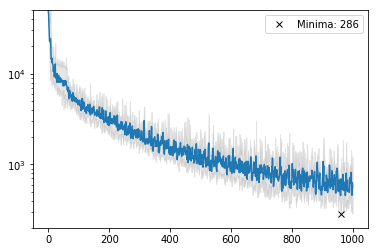

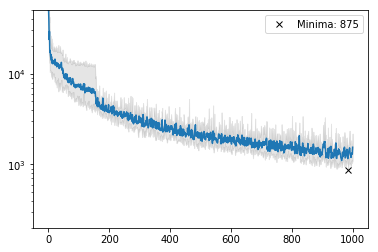

In [44]:
drawLoss(valLosses(AEloss, 'loss'), filename='plotLoss_AE_train.pdf', ylim=[200,50000])
drawLoss(valLosses(DAELoss, 'loss'), filename='plotLoss_DAE_train.pdf', ylim=[200,50000])
drawLoss(valLosses(SAELoss, 'loss'), filename='plotLoss_SAE_train.pdf', ylim=[200,50000])
drawLoss(valLosses(DSAELoss, 'loss'), filename='plotLoss_DSAE_train.pdf', ylim=[200,50000])
drawLoss(valLosses(DpLoss, 'loss'), filename='plotLoss_DP_train.pdf', ylim=[200,50000])
drawLoss(valLosses(DSDAELoss, 'loss'), filename='plotLoss_DSDAE_train.pdf', ylim=[200,50000])

In [48]:
summarizeKFold(hists, key='val_f1score', f=max)

/home/mafalda/THCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,val_loss,val_acc,val_precision,val_recall,loss,acc,precision,recall,val_f1score
0,7.00% (±4.28%),98.77% (±1.00%),99.22% (±0.80%),99.41% (±0.89%),2.71% (±3.52%),99.65% (±0.46%),99.80% (±0.32%),99.81% (±0.21%),99.31% (±0.57%)
1,14.49% (±13.44%),98.77% (±1.33%),99.21% (±0.82%),99.41% (±0.87%),0.26% (±0.32%),99.82% (±0.24%),99.85% (±0.22%),99.95% (±0.11%),99.31% (±0.75%)


In [ ]:
hists = experienceB(newX, y, denoisingAutoEncoder(0.1), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder


In [ ]:
summarizeKFold(hists, key='val_f1score', f=max)

In [ ]:
hists = experienceB(newX, y, sparseAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)

[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder


In [56]:
summarizeKFold(hists, key='val_f1score', f=max)

,val_loss,val_acc,val_precision,val_recall,loss,acc,precision,recall,val_f1score
0,8520.52% (±6800.11%),89.61% (±0.69%),89.77% (±0.46%),99.80% (±0.45%),11643.59% (±9920.08%),87.02% (±3.94%),89.70% (±0.14%),96.61% (±4.98%),94.52% (±0.39%)
1,2380.35% (±2175.17%),89.97% (±0.45%),89.95% (±0.43%),100.00% (±0.00%),2847.17% (±2390.62%),89.26% (±0.67%),89.84% (±0.15%),99.27% (±0.97%),94.71% (±0.24%)


In [ ]:
hists = experienceB(newX, y, sparseAutoEncoder(encodingDim = 512), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder


In [57]:
hists = experienceB(newX, y, deepAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)

[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder
[INFO] Training Autoencoder
[INFO] Finetuning model with top layers from Encoder
[INFO] Finetuning model with top layers from Autoencoder


In [59]:
summarizeKFold(hists, key='val_f1score', f=max)

/home/mafalda/THCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,val_loss,val_acc,val_precision,val_recall,loss,acc,precision,recall,val_f1score
0,12.55% (±12.27%),98.77% (±1.00%),99.22% (±0.80%),99.41% (±0.89%),0.18% (±0.22%),100.00% (±0.00%),100.00% (±0.00%),100.00% (±0.00%),99.31% (±0.57%)
1,18.14% (±13.19%),98.59% (±1.18%),99.21% (±0.44%),99.21% (±1.08%),2.86% (±4.66%),99.12% (±0.95%),99.60% (±0.45%),99.41% (±1.04%),99.21% (±0.67%)


In [17]:
histsxpto = experienceB(newX, y, deepSparseDenoisingAutoEncoder(dims=[1024, 512, 256]), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)
summarizeKFold(histsxpto, key='val_f1score', f=max)

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


/home/mafalda/THCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,val_loss,val_acc,val_precision,val_recall,loss,acc,precision,recall,val_f1score
0,6107.77% (±5463.60%),89.79% (±0.43%),89.79% (±0.43%),100.00% (±0.00%),9614.16% (±8185.25%),87.94% (±1.87%),90.66% (±1.97%),96.67% (±4.36%),94.62% (±0.24%)
1,9650.12% (±4953.88%),89.97% (±0.45%),90.58% (±1.63%),99.25% (±1.68%),15219.44% (±7537.84%),86.58% (±5.18%),91.29% (±1.42%),93.96% (±7.63%),94.69% (±0.23%)


In [19]:
hists = experienceB(newX, y, denoisingSparseAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=True)
summarizeKFold(hists, key='val_f1score', f=max).to_latex()

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


'\\begin{tabular}{llllllllll}\n\\toprule\n{} &              val\\_loss &          val\\_acc &    val\\_precision &        val\\_recall &                   loss &              acc &        precision &           recall &      val\\_f1score \\\\\n\\midrule\n0 &  9516.41\\% (±3278.30\\%) &  89.79\\% (±0.43\\%) &  89.79\\% (±0.43\\%) &  100.00\\% (±0.00\\%) &  15109.13\\% (±6438.70\\%) &  85.56\\% (±4.07\\%) &  89.53\\% (±0.32\\%) &  94.99\\% (±4.80\\%) &  94.62\\% (±0.24\\%) \\\\\n1 &  5546.00\\% (±4184.81\\%) &  90.32\\% (±0.86\\%) &  90.89\\% (±1.94\\%) &   99.20\\% (±1.78\\%) &   7539.46\\% (±5508.54\\%) &  87.19\\% (±5.85\\%) &  92.18\\% (±1.63\\%) &  94.10\\% (±6.36\\%) &  94.83\\% (±0.39\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [20]:
summarizeKFold(hists, key='val_f1score', f=max)

,val_loss,val_acc,val_precision,val_recall,loss,acc,precision,recall,val_f1score
0,9516.41% (±3278.30%),89.79% (±0.43%),89.79% (±0.43%),100.00% (±0.00%),15109.13% (±6438.70%),85.56% (±4.07%),89.53% (±0.32%),94.99% (±4.80%),94.62% (±0.24%)
1,5546.00% (±4184.81%),90.32% (±0.86%),90.89% (±1.94%),99.20% (±1.78%),7539.46% (±5508.54%),87.19% (±5.85%),92.18% (±1.63%),94.10% (±6.36%),94.83% (±0.39%)


Fixed-Weights Experiments

In [14]:
hists = experienceB(newX, y, basicAutoEncoder(), nEpochsAE=1, nEpochs=1, nFolds=2, trainVerbose=True,aeFineTune=False)
summarizeKFold(hists, key='val_accuracy', f=max).to_latex()

NameError: name 'basicAutoEncoder' is not defined

In [22]:
hists = experienceB(newX, y, denoisingAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=False)
summarizeKFold(hists, key='val_f1score', f=max).to_latex()

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


'\\begin{tabular}{llllllllll}\n\\toprule\n{} &          val\\_loss &          val\\_acc &    val\\_precision &       val\\_recall &            loss &              acc &         precision &           recall &      val\\_f1score \\\\\n\\midrule\n0 &  13.40\\% (±10.87\\%) &  98.59\\% (±1.59\\%) &  99.22\\% (±0.81\\%) &  99.21\\% (±1.30\\%) &  2.00\\% (±2.73\\%) &  99.43\\% (±0.91\\%) &   99.70\\% (±0.54\\%) &  99.67\\% (±0.49\\%) &  99.21\\% (±0.91\\%) \\\\\n1 &  15.57\\% (±14.74\\%) &  98.59\\% (±1.59\\%) &  99.03\\% (±1.17\\%) &  99.41\\% (±0.89\\%) &  0.11\\% (±0.08\\%) &  99.96\\% (±0.10\\%) &  100.00\\% (±0.00\\%) &  99.95\\% (±0.11\\%) &  99.22\\% (±0.89\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [23]:
hists = experienceB(newX, y, sparseAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=False)
summarizeKFold(hists, key='val_f1score', f=max).to_latex()

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


'\\begin{tabular}{llllllllll}\n\\toprule\n{} &               val\\_loss &          val\\_acc &    val\\_precision &       val\\_recall &                   loss &              acc &        precision &           recall &      val\\_f1score \\\\\n\\midrule\n0 &  30126.94\\% (±1972.50\\%) &  97.36\\% (±2.23\\%) &  97.88\\% (±1.72\\%) &  99.21\\% (±0.83\\%) &  32718.55\\% (±2859.56\\%) &  97.49\\% (±2.21\\%) &  98.02\\% (±2.39\\%) &  99.28\\% (±0.68\\%) &  98.54\\% (±1.25\\%) \\\\\n1 &  30133.73\\% (±1963.46\\%) &  97.72\\% (±2.45\\%) &  99.21\\% (±1.26\\%) &  98.22\\% (±2.04\\%) &  32634.12\\% (±2745.43\\%) &  98.68\\% (±2.24\\%) &  99.20\\% (±1.66\\%) &  99.36\\% (±0.84\\%) &  98.71\\% (±1.40\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [24]:
hists = experienceB(newX, y, denoisingSparseAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=False)
summarizeKFold(hists, key='val_f1score', f=max).to_latex()

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


'\\begin{tabular}{llllllllll}\n\\toprule\n{} &               val\\_loss &          val\\_acc &    val\\_precision &       val\\_recall &                   loss &              acc &        precision &           recall &      val\\_f1score \\\\\n\\midrule\n0 &  27713.78\\% (±1662.52\\%) &  98.59\\% (±1.00\\%) &  99.62\\% (±0.85\\%) &  98.82\\% (±1.29\\%) &  34276.37\\% (±3299.86\\%) &  99.78\\% (±0.27\\%) &  99.90\\% (±0.13\\%) &  99.85\\% (±0.22\\%) &  99.21\\% (±0.57\\%) \\\\\n1 &  27714.13\\% (±1664.41\\%) &  98.77\\% (±1.00\\%) &  99.41\\% (±0.88\\%) &  99.21\\% (±0.44\\%) &  34461.33\\% (±3222.26\\%) &  98.64\\% (±1.59\\%) &  98.93\\% (±1.15\\%) &  99.56\\% (±0.60\\%) &  99.31\\% (±0.56\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
hists = experienceB(newX, y, deepAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=False)
summarizeKFold(hists, key='val_f1_score', f=max)

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


,val_loss,val_acc,val_precision,val_recall,val_f1_score,loss,acc,precision,recall,f1_score
0,14.79% (±8.29%),97.01% (±1.46%),97.72% (±1.71%),99.03% (±1.19%),98.35% (±0.81%),5.87% (±7.24%),97.75% (±3.34%),98.21% (±3.21%),99.42% (±0.37%),98.78% (±1.79%)
1,39.45% (±31.76%),94.38% (±4.46%),97.06% (±2.19%),96.67% (±3.14%),96.85% (±2.51%),0.72% (±0.90%),99.78% (±0.31%),99.90% (±0.22%),99.85% (±0.22%),99.88% (±0.18%)


In [21]:
summarizeKFold(hists, key='val_f1_score', f=max).to_latex()

'\\begin{tabular}{lllllllllll}\n\\toprule\n{} &          val\\_loss &          val\\_acc &    val\\_precision &       val\\_recall &     val\\_f1\\_score &            loss &              acc &        precision &           recall &         f1\\_score \\\\\n\\midrule\n0 &   14.79\\% (±8.29\\%) &  97.01\\% (±1.46\\%) &  97.72\\% (±1.71\\%) &  99.03\\% (±1.19\\%) &  98.35\\% (±0.81\\%) &  5.87\\% (±7.24\\%) &  97.75\\% (±3.34\\%) &  98.21\\% (±3.21\\%) &  99.42\\% (±0.37\\%) &  98.78\\% (±1.79\\%) \\\\\n1 &  39.45\\% (±31.76\\%) &  94.38\\% (±4.46\\%) &  97.06\\% (±2.19\\%) &  96.67\\% (±3.14\\%) &  96.85\\% (±2.51\\%) &  0.72\\% (±0.90\\%) &  99.78\\% (±0.31\\%) &  99.90\\% (±0.22\\%) &  99.85\\% (±0.22\\%) &  99.88\\% (±0.18\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [22]:
hists = experienceB(newX, y, deepSparseDenoisingAutoEncoder(), nEpochsAE=1000, nEpochs=1000, nFolds=5, trainVerbose=False,aeFineTune=False)
summarizeKFold(hists, key='val_f1_score', f=max).to_latex()

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


'\\begin{tabular}{lllllllllll}\n\\toprule\n{} &               val\\_loss &          val\\_acc &    val\\_precision &       val\\_recall &     val\\_f1\\_score &                   loss &              acc &        precision &           recall &         f1\\_score \\\\\n\\midrule\n0 &  24451.94\\% (±2853.10\\%) &  97.19\\% (±2.00\\%) &  98.09\\% (±1.49\\%) &  98.82\\% (±1.62\\%) &  98.43\\% (±1.12\\%) &  28878.06\\% (±1533.04\\%) &  97.93\\% (±2.42\\%) &  98.58\\% (±2.22\\%) &  99.18\\% (±0.75\\%) &  98.86\\% (±1.31\\%) \\\\\n1 &  24465.35\\% (±2846.22\\%) &  96.66\\% (±1.80\\%) &  98.25\\% (±0.80\\%) &  98.04\\% (±1.55\\%) &  98.13\\% (±1.02\\%) &  28938.30\\% (±1633.68\\%) &  98.72\\% (±1.09\\%) &  99.46\\% (±0.31\\%) &  99.13\\% (±0.98\\%) &  99.29\\% (±0.61\\%) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [20]:
#testing sumarizeKFold changes
test = experienceB(newX, y, basicAutoEncoder(), nEpochsAE=1, nEpochs=1, nFolds=5, trainVerbose=False,aeFineTune=True)

[FOLD 1] Training Autoencoder
[FOLD 1] Finetuning model with top layers from Encoder
[FOLD 1] Finetuning model with top layers from Autoencoder
[FOLD 2] Training Autoencoder
[FOLD 2] Finetuning model with top layers from Encoder
[FOLD 2] Finetuning model with top layers from Autoencoder
[FOLD 3] Training Autoencoder
[FOLD 3] Finetuning model with top layers from Encoder
[FOLD 3] Finetuning model with top layers from Autoencoder
[FOLD 4] Training Autoencoder
[FOLD 4] Finetuning model with top layers from Encoder
[FOLD 4] Finetuning model with top layers from Autoencoder
[FOLD 5] Training Autoencoder
[FOLD 5] Finetuning model with top layers from Encoder
[FOLD 5] Finetuning model with top layers from Autoencoder


In [89]:
### Experimenting some visualizations 

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.33, random_state=seed, stratify=y)
autoencoder, encoder = denoisingAutoEncoder()(Xtrain)

In [90]:
filepath = "autoencoderVis.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=True, save_best_only=True, mode='min')

print('Training Autoencoder')
autoencoder.fit(Xtrain, Xtrain, epochs=100, batch_size=200, validation_data=(Xval, Xval),verbose=True, callbacks = [checkpoint])

Training Autoencoder
Train on 380 samples, validate on 188 samples
Epoch 1/100
380/380 [==============================] - 1s 4ms/step - loss: 19724.0653 - val_loss: 13592.9717

Epoch 00001: val_loss improved from inf to 13592.97168, saving model to autoencoderVis.best.hdf5
Epoch 2/100
380/380 [==============================] - 1s 3ms/step - loss: 18781.6388 - val_loss: 11536.1758

Epoch 00002: val_loss improved from 13592.97168 to 11536.17578, saving model to autoencoderVis.best.hdf5
Epoch 3/100
380/380 [==============================] - 1s 3ms/step - loss: 15846.3003 - val_loss: 7771.0605

Epoch 00003: val_loss improved from 11536.17578 to 7771.06055, saving model to autoencoderVis.best.hdf5
Epoch 4/100
380/380 [==============================] - 1s 3ms/step - loss: 11202.2436 - val_loss: 5248.2065

Epoch 00004: val_loss improved from 7771.06055 to 5248.20654, saving model to autoencoderVis.best.hdf5
Epoch 5/100
380/380 [==============================] - 1s 3ms/step - loss: 7876.0629 -

Epoch 43/100
380/380 [==============================] - 1s 3ms/step - loss: 2015.7394 - val_loss: 1576.9972

Epoch 00043: val_loss improved from 1618.11865 to 1576.99719, saving model to autoencoderVis.best.hdf5
Epoch 44/100
380/380 [==============================] - 1s 3ms/step - loss: 1956.7562 - val_loss: 1664.0126

Epoch 00044: val_loss did not improve from 1576.99719
Epoch 45/100
380/380 [==============================] - 1s 3ms/step - loss: 2048.2125 - val_loss: 1832.9209

Epoch 00045: val_loss did not improve from 1576.99719
Epoch 46/100
380/380 [==============================] - 1s 3ms/step - loss: 2161.7189 - val_loss: 1614.8485

Epoch 00046: val_loss did not improve from 1576.99719
Epoch 47/100
380/380 [==============================] - 1s 3ms/step - loss: 1844.0331 - val_loss: 1480.1394

Epoch 00047: val_loss improved from 1576.99719 to 1480.13940, saving model to autoencoderVis.best.hdf5
Epoch 48/100
380/380 [==============================] - 1s 3ms/step - loss: 1740.7933 -

Epoch 90/100
380/380 [==============================] - 1s 3ms/step - loss: 1163.8851 - val_loss: 964.7992

Epoch 00090: val_loss improved from 998.70331 to 964.79919, saving model to autoencoderVis.best.hdf5
Epoch 91/100
380/380 [==============================] - 1s 3ms/step - loss: 1130.0205 - val_loss: 976.0574

Epoch 00091: val_loss did not improve from 964.79919
Epoch 92/100
380/380 [==============================] - 1s 3ms/step - loss: 1093.9677 - val_loss: 1014.8679

Epoch 00092: val_loss did not improve from 964.79919
Epoch 93/100
380/380 [==============================] - 1s 3ms/step - loss: 1156.2693 - val_loss: 959.8472

Epoch 00093: val_loss improved from 964.79919 to 959.84717, saving model to autoencoderVis.best.hdf5
Epoch 94/100
380/380 [==============================] - 2s 4ms/step - loss: 1183.0817 - val_loss: 983.5356

Epoch 00094: val_loss did not improve from 959.84717
Epoch 95/100
380/380 [==============================] - 1s 3ms/step - loss: 1257.8118 - val_loss: 

In [ ]:
def visualize(encodingLayer):
    layerDim = encodingLayer.get_config()['units']
    layerWeights = encodingLayer.get_weights()[0].transpose()
    layerBiases = np.array([encodingLayer.get_weights()[1]]).transpose()

    import matplotlib.pyplot as plt
    from matplotlib import ticker
    from matplotlib import gridspec
    import seaborn as sns 

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

    plt.rcParams["figure.figsize"] = 20,15
    gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
    f, (ax, ax2) = plt.subplots(ncols=2)
    f.subplots_adjust(wspace=0.01)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    # Weights
    ax = plt.subplot(gs[0])
    sns.heatmap(layerWeights, cmap=cmap, cbar=False, yticklabels=(list(range(layerDim))), xticklabels=[], ax=ax)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

    # Biases
    ax2 = plt.subplot(gs[1])
    sns.heatmap(layerBiases, cmap=cmap, cbar=False, yticklabels=[], xticklabels=[], ax=ax2)

In [ ]:
bestModel = load_model('autoencoderVis.best.hdf5')
encodingLayer = bestModel.layers[2]
visualize(encodingLayer)